# Notebook to perform evolutionary simulations to compare mutational signatures with or without clonal selection

We first import relevant modules. We will rely mostly on msprime for the analyses (see install instructions and tutorials at https://tskit.dev/msprime/docs/stable/intro.html)

In [25]:
import sys
import msprime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import SVG, display
import math

## Build demographic model

We create a simple model of an exponentially growing tumor cell population (growth rate r_T). We assume that this cell population started from a single cell acquiring a driver mutation at time T_T, at which point this cell split from the normal cell population.

In [26]:
demo_exp = msprime.Demography()
r_T = 0.1/2
T_T = 80*2
N_T = 1 / math.exp(-r_T*T_T)
N_N = 1e2
mu  = 5e-8

num_replicates = 1600

demo_exp.add_population(
    name="Normal",
    description="Normal_cell_population",
    initial_size=N_N,
    initially_active=True,
)
demo_exp.add_population(
    name="Tumor",
    description="Tumor_cell_population",
    initial_size=N_T,
    growth_rate=r_T,
)
demo_exp.add_population_split(
    time=T_T, derived=["Tumor"], ancestral="Normal"
)

demo_exp.debug()

For illustrative purposes, we simulate a single genealogy (ts) under this demographic model. We set ploidy to 1 and recombination to 0 to mimick tumor clonal evolution. We set the sample size to 60 for visualization purposes.

We also simulate replicate simulations, with one tree per locus (1600 replicates, to match the median number of SNVs in the mice experiments from Riva et al. Nat Genet 2020). This corresponds to an "infinite cells" assumption, where each sequencing reads comes from a different cell. 

In [27]:
ts= msprime.sim_ancestry(samples=[msprime.SampleSet(1,population="Normal"),msprime.SampleSet(60,population="Tumor")], 
    sequence_length=1e6, random_seed=1234,ploidy=1,recombination_rate=0,discrete_genome=False,
    demography=demo_exp)

rts= msprime.sim_ancestry(samples=[msprime.SampleSet(1,population="Normal"),msprime.SampleSet(60,population="Tumor")], 
    sequence_length=1e6, random_seed=1234,ploidy=1,recombination_rate=0,discrete_genome=False,
    num_replicates=num_replicates,
    demography=demo_exp)

We then simulate mutations in the illustrative example ts, for each of 6 mutational signatures. We use the proportions of each signature observed in the study of Riva et al. Nat Genet 2020

In [28]:
sig_props = [0.004693080, 0.136151442, 0.006801387, 0.125964302, 0.710968902, 0.015420887]
sig_labels = ["mSBS1","mSBS5","mSBS17","mSBS18","mSBS40","mSBS_N3"]

mts_SBS1   = msprime.sim_mutations(ts, rate=mu*sig_props[0], random_seed=8,model=msprime.InfiniteSites())
mts_SBS5   = msprime.sim_mutations(ts, rate=mu*sig_props[1], random_seed=9,model=msprime.InfiniteSites(),keep=True,record_provenance=True)
mts_SBS17  = msprime.sim_mutations(ts, rate=mu*sig_props[2], random_seed=10,model=msprime.InfiniteSites(),keep=True,record_provenance=True)
mts_SBS18  = msprime.sim_mutations(ts, rate=mu*sig_props[3], random_seed=11,model=msprime.InfiniteSites(),keep=True,record_provenance=True)
mts_SBS40  = msprime.sim_mutations(ts, rate=mu*sig_props[4], random_seed=12,model=msprime.InfiniteSites(),keep=True,record_provenance=True)
mts_SBS_N3 = msprime.sim_mutations(ts, rate=mu*sig_props[5], random_seed=13,model=msprime.InfiniteSites(),keep=True,record_provenance=True)

We also simulate a more realistic site frequency spectrum using a simple mutation model where one mutation is drawn for each locus (entries from rts).

In [29]:
SFS = pd.DataFrame(0, index =range(60), columns = ["mSBS1","mSBS5","mSBS17","mSBS18","mSBS40","mSBS_N3"] ) #create a SFS matrix with each signature as a separate column

for i, tst in enumerate(rts): # for each simulated genealogy (locus), we simulate a single mutation
    tree = tst.first() # get tree
    SFStmp = tst.allele_frequency_spectrum(mode="branch",sample_sets=[ts.samples(population=1)],span_normalise=False ,polarised=True)[1:] #get branch length SFS
    SFStmp = SFStmp / sum(SFStmp) #normalize
    mut_labels_tmp = np.random.choice(sig_labels, 1, p=sig_props)[0] # randomly choose a signature based on their proportions
    n_tmp = np.random.choice(range(60), 1, p=SFStmp)[0] # randomly choose one entry where the mutation will occur based on their relative branch length
    SFS.at[n_tmp,mut_labels_tmp] = SFS[mut_labels_tmp][n_tmp] + 1 #update the corresponding entry in the SFS

We write the results to a file.

In [30]:
SFS.to_csv("SBS_bigbang.csv")

### Plotting

We draw the illustrative example for a supplementary figure

In [31]:
svg_size = (400, 400) # Height and width for the SVG: optional but useful for this notebook
edge_style = ".n13 .edge {stroke: blue; stroke-width: 2px}"
css_string = (
    ".tree .lab {font-family: sans-serif}"
    # Normal X axis tick labels have dominant baseline: hanging, but it needs centring when rotated
    + ".y-axis .tick .lab {font-size: 70%}" #text-anchor: start; dominant-baseline: central; transform: rotate(90deg); }"
    + ".y-axis .grid {stroke: #DDDDDD}"
    + ".node > .sym {display: none}"
)
default_muts_SBS1   = ".mut .lab {fill: #C0392B} .mut .sym {stroke: #C0392B}"  # all other muts in gray
default_muts_SBS5   = ".mut .lab {fill: #FFC642} .mut .sym {stroke: #FFC642}"  # all other muts in gray
default_muts_SBS17  = ".mut .lab {fill: #00ACC1} .mut .sym {stroke: #00ACC1}"  # all other muts in gray
default_muts_SBS18  = ".mut .lab {fill: #FFA726} .mut .sym {stroke: #FFA726}"  # all other muts in gray
default_muts_SBS40  = ".mut .lab {fill: #2874A6} .mut .sym {stroke: #2874A6}"  # all other muts in gray
default_muts_SBS_N3 = ".mut .lab {fill: #4D4D4D} .mut .sym {stroke: #4D4D4D}"  # all other muts in gray
mut_labels = {"": n for n in np.arange(60)}
nd_labs = {"": n for n in np.arange(10)}
y_ticks = {0:"present",T_T:"Tumor initiation",ts.tables.nodes.time[120]:"Tumor-Normal TMRCA"}#ts.tables.nodes.time

svg_string_SBS1 = mts_SBS1.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS1,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

svg_string_SBS5 = mts_SBS5.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS5,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

svg_string_SBS17 = mts_SBS17.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS17,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

svg_string_SBS18 = mts_SBS18.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS18,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

svg_string_SBS40 = mts_SBS40.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS40,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

svg_string_SBS_N3 = mts_SBS_N3.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS_N3,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

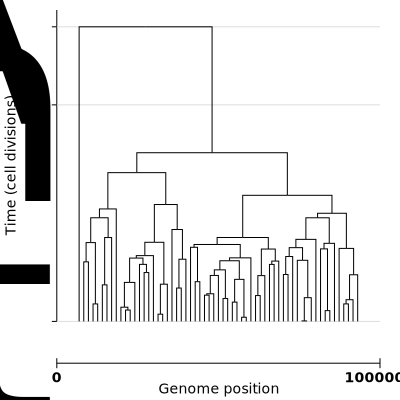

In [32]:
display(svg_string_SBS1)
with open('toysimul_bigbang_SBS1.svg', 'w') as f:
    f.write(svg_string_SBS1)

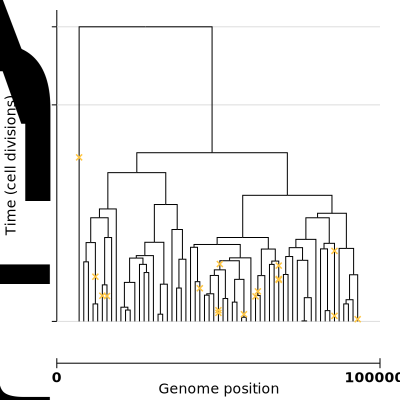

In [33]:
display(svg_string_SBS5)
with open('toysimul_bigbang_SBS5.svg', 'w') as f:
    f.write(svg_string_SBS5)

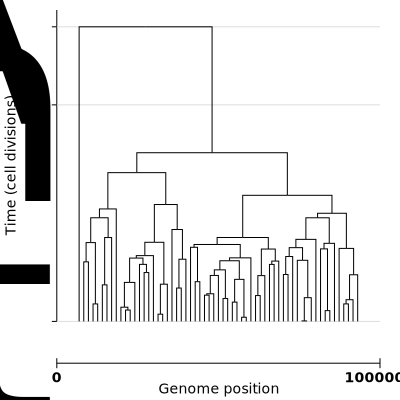

In [34]:
display(svg_string_SBS17)
with open('toysimul_bigbang_SBS17.svg', 'w') as f:
    f.write(svg_string_SBS17)

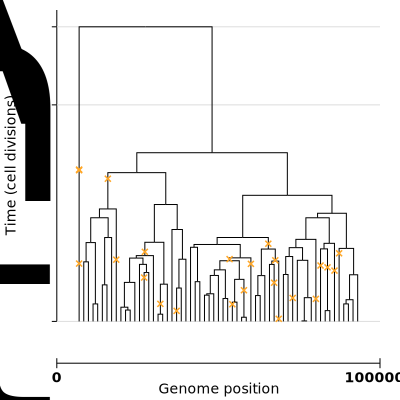

In [35]:
display(svg_string_SBS18)
with open('toysimul_bigbang_SBS18.svg', 'w') as f:
    f.write(svg_string_SBS18)

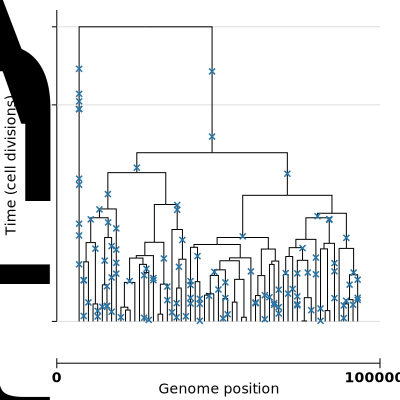

In [36]:
display(svg_string_SBS40)
with open('toysimul_bigbang_SBS40.svg', 'w') as f:
    f.write(svg_string_SBS40)

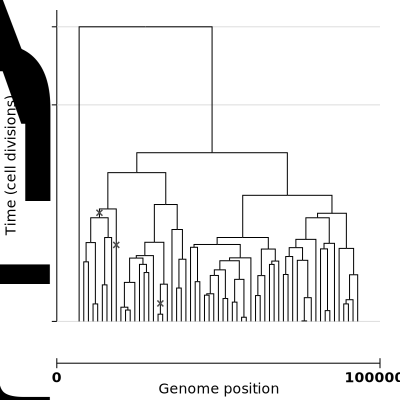

In [37]:
display(svg_string_SBS_N3)
with open('toysimul_bigbang_SBS_N3.svg', 'w') as f:
    f.write(svg_string_SBS_N3)

## Model with selection

We now simulate a model with clonal selection, where a clone with faster growth (r_s > r_T) appears at time T_s, and rises to frequency 0.75 so at the time of sampling, both the ancestral clone and the selected subclone are present.

In [38]:
demo_exp = msprime.Demography()
T_s = T_T/2
r_s = r_T*5

demo_exp.add_population(
    name="Normal",
    description="Normal_cell_population",
    initial_size=N_N,
    initially_active=True,
)
demo_exp.add_population(
    name="Tumor_subclone1",
    description="Tumor_cell_population_subclone1",
    initial_size=N_T*0.25,
    growth_rate=r_T,
    initially_active=True
)

demo_exp.add_population(
    name="Tumor_subclone2",
    description="Tumor_cell_population_subclone2",
    initial_size=N_T*0.75,
    growth_rate=r_s,
)


demo_exp.add_population_split(
    time=T_s, derived=["Tumor_subclone2"], ancestral="Tumor_subclone1"
)

demo_exp.add_population_split(
    time=T_T, derived=["Tumor_subclone1"], ancestral="Normal"
)


demo_exp.debug()

In [39]:
ts_s = msprime.sim_ancestry(samples=[msprime.SampleSet(1,population="Normal"),
        msprime.SampleSet(60*0.2,population="Tumor_subclone1"),
        msprime.SampleSet(60*0.8,population="Tumor_subclone2")], 
    sequence_length=1e6, random_seed=21,ploidy=1,recombination_rate=0,discrete_genome=False,
     demography=demo_exp)

rts_s = msprime.sim_ancestry(samples=[msprime.SampleSet(1,population="Normal"),
        msprime.SampleSet(60*0.2,population="Tumor_subclone1"),
        msprime.SampleSet(60*0.8,population="Tumor_subclone2")], 
    sequence_length=1e6, random_seed=1234,ploidy=1,recombination_rate=0,discrete_genome=False,
    num_replicates=num_replicates,
    demography=demo_exp)

In [40]:
SFS_s = pd.DataFrame(0, index =range(60), columns = ["mSBS1","mSBS5","mSBS17","mSBS18","mSBS40","mSBS_N3"] )

for i, tst in enumerate(rts_s):
    tree = tst.first()
    SFStmp = tst.allele_frequency_spectrum(mode="branch",sample_sets=[np.arange(1,61)],span_normalise=False ,polarised=True)[1:]
    SFStmp = SFStmp / sum(SFStmp)
    mut_labels_tmp = np.random.choice(sig_labels, 1, p=sig_props)[0]
    n_tmp = np.random.choice(range(60), 1, p=SFStmp)[0]
    SFS_s.at[n_tmp,mut_labels_tmp] = SFS_s[mut_labels_tmp][n_tmp] + 1


mts_SBS1_s   = msprime.sim_mutations(ts_s, rate=1.91*mu*sig_props[0], random_seed=5678,model=msprime.InfiniteSites(),keep=True,record_provenance=True)
mts_SBS5_s   = msprime.sim_mutations(ts_s, rate=1.91*mu*sig_props[1], random_seed=9,model=msprime.InfiniteSites(),keep=True,record_provenance=True)
mts_SBS17_s  = msprime.sim_mutations(ts_s, rate=1.91*mu*sig_props[2], random_seed=10,model=msprime.InfiniteSites(),keep=True,record_provenance=True)
mts_SBS18_s  = msprime.sim_mutations(ts_s, rate=1.91*mu*sig_props[3], random_seed=11,model=msprime.InfiniteSites(),keep=True,record_provenance=True)
mts_SBS40_s  = msprime.sim_mutations(ts_s, rate=1.91*mu*sig_props[4], random_seed=12,model=msprime.InfiniteSites(),keep=True,record_provenance=True)
mts_SBS_N3_s = msprime.sim_mutations(ts_s, rate=1.91*mu*sig_props[5], random_seed=13,model=msprime.InfiniteSites(),keep=True,record_provenance=True)

In [41]:
SFS_s.to_csv("SBS_clonalsel.csv")

### Plotting

In [42]:
y_ticks = {0:"present",T_T:"Tumor initiation",ts_s.tables.nodes.time[120]:"Tumor-Normal TMRCA",T_s:"Clonal sweep start"}#ts.tables.nodes.time
nd_labels = ["" for x in range(60)]  # An array of labels for the mutations
mut_labels = ["" for x in range(1)]  # An array of labels for the mutations

css_sel = ".node.p2 > .sym {fill: red}"

svg_string_SBS1_s = mts_SBS1_s.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS1 + css_sel,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

svg_string_SBS5_s = mts_SBS5_s.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS5+ css_sel,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

svg_string_SBS17_s = mts_SBS17_s.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS17+ css_sel,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

svg_string_SBS18_s = mts_SBS18_s.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS18+ css_sel,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

svg_string_SBS40_s = mts_SBS40_s.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS40+ css_sel,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

svg_string_SBS_N3_s = mts_SBS_N3_s.draw_svg(
    size=svg_size,
    y_axis=True, 
    y_ticks=y_ticks, 
    y_label="Time (cell divisions)",  # optional: show a time scale on the left
    time_scale="time", x_scale="treewise",  # Force same axis settings as the text view
    style=css_string + default_muts_SBS_N3+ css_sel,
    y_gridlines=True,
    mutation_labels=mut_labels,
    node_labels=nd_labs,
)

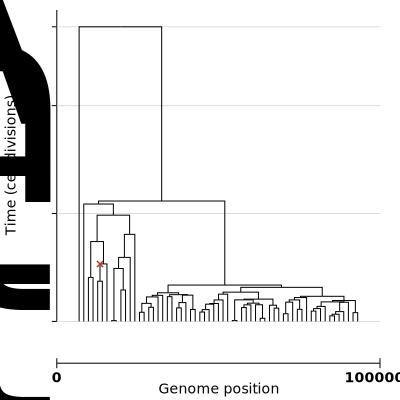

In [43]:
display(svg_string_SBS1_s)
with open('toysimul_clonalsel_SBS1.svg', 'w') as f:
    f.write(svg_string_SBS1_s)

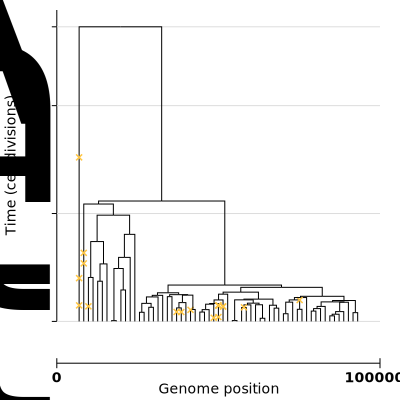

In [44]:
display(svg_string_SBS5_s)
with open('toysimul_clonalsel_SBS5.svg', 'w') as f:
    f.write(svg_string_SBS5_s)

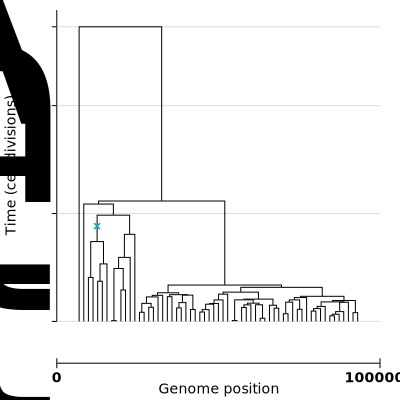

In [45]:
display(svg_string_SBS17_s)
with open('toysimul_clonalsel_SBS17.svg', 'w') as f:
    f.write(svg_string_SBS17_s)

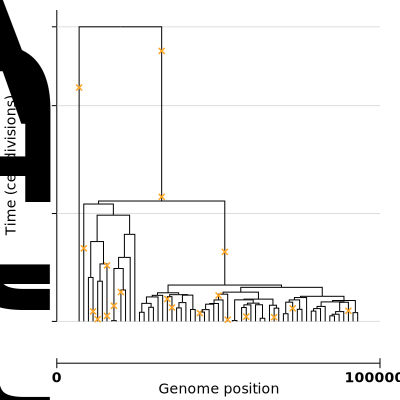

In [46]:
display(svg_string_SBS18_s)
with open('toysimul_clonalsel_SBS18.svg', 'w') as f:
    f.write(svg_string_SBS18_s)

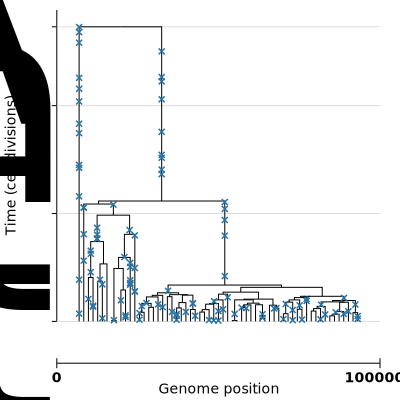

In [47]:
display(svg_string_SBS40_s)
with open('toysimul_clonalsel_SBS40.svg', 'w') as f:
    f.write(svg_string_SBS40_s)

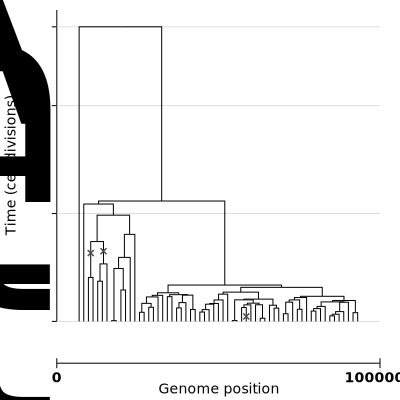

In [48]:
display(svg_string_SBS_N3_s)
with open('toysimul_clonalsel_SBS_N3.svg', 'w') as f:
    f.write(svg_string_SBS_N3_s)